In [9]:
import itertools
import matplotlib

from operator import itemgetter
from sklearn.decomposition import PCA
import sys
sys.path.append('../methods')
from settings import *
import helpers
%matplotlib inline
config_dict = helpers.process_config("config")

# Output
figures_dir = config_dict["out_dir"]["figures"]
supplement_dir = config_dict["out_dir"]["sup"]
results_dir = config_dict["out_dir"]["results"]

# Strain Info

strain_info = pd.read_csv(strain_info_file, index_col=0)
strains = config_dict["strains"]["all"].split()
over = config_dict['strains']['over'].split()
under = config_dict['strains']['under'].split()

b1 = config_dict['strains']['b1_strains'].split()
b2 = config_dict['strains']['b2_strains'].split()

# Counts/TPMs
counts_file = config_dict["data"]["core_tpms"]

/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/methods/helpers.py


In [2]:
strain_info.index = ["{} ".format(i) for i in strain_info.index]

In [3]:
def find_pc1_pc2(df, meta):
    df = df.T
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    pDf = (pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
           .set_index(df.index))
    pc1_var = round(pca.explained_variance_ratio_[0] * 100, 2)
    pc2_var = round(pca.explained_variance_ratio_[1] * 100, 2)
    pDf2 = pDf.merge(meta, left_index=True, right_index=True)
    return pDf2, pc1_var, pc2_var


def plotPCA(pDf, pc1_var, pc2_var, colorby, col, nameby="", el=False): 
    sns.set_style("ticks")
    group = pDf[colorby].unique()
    assert len(group) <= len(col)
    fig = plt.figure(figsize=(8, 8))
    for g, c in zip(group, col):
        df = pDf[pDf[colorby] == g]
        x, y = df[["PC1"]].values, df[["PC2"]].values
        ax = plt.scatter(x, y, c=c, s=150, label=g)  
        if el:
            pts = np.asarray([[float(a), float(b)] for a, b in zip(x, y)])
            plot_point_cov(pts, nstd=2, alpha=0.1, color=c)
        if nameby:
            labels = df[nameby]
            for label, pc1, pc2 in zip(labels, x, y):
                plt.annotate(label, xy=(pc1, pc2), xytext=(-5, 7), textcoords="offset points",
                             fontsize=14)
        plt.xlabel('Principal Component 1, {} %'.format(pc1_var), fontsize=15)
        plt.ylabel('Principal Component 2, {} %'.format(pc2_var), fontsize=15)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(fontsize=18, frameon=True)
    return fig

In [4]:
tpms = pd.read_csv(counts_file, index_col=0)
tpms = tpms[[c for c in tpms.columns if 'tpm' in c]]
ntpms = tpms.apply(invnorm)
ntpms.columns = [sample_label_from_sample_name(c.split("_tpm")[0]) for c in ntpms.columns]
ntpms.head()

,HM01 | URINE,HM01 | PATIENT,HM03 | URINE,HM03 | PATIENT,HM06 | URINE,HM06 | PATIENT,HM07 | URINE,HM07 | PATIENT,HM14 | URINE,HM14 | PATIENT,...,HM57 | URINE,HM57 | PATIENT,HM60 | URINE,HM60 | PATIENT,HM66 | URINE,HM66 | PATIENT,HM68 | URINE,HM68 | PATIENT,HM86 | URINE,HM86 | PATIENT
b4182,-1.188012,-1.109430,-1.264135,-1.195702,-0.940124,-1.016354,-1.055125,-0.929156,-1.566525,-1.679256,...,-0.963907,-0.238447,-1.221193,-1.037161,-1.055125,-0.367117,-1.235255,-1.257858,-1.188012,-1.025902
b1960,-0.925525,-0.168980,-0.704146,-0.215180,-0.677755,-0.485120,-0.516179,-0.533529,-0.554343,-0.252079,...,-0.899733,0.034493,-0.789056,-0.410941,-1.011614,-0.068080,-0.458716,-0.074711,-0.753437,-0.326976
b2866,-0.061452,-0.785192,-0.614878,-1.336750,-0.418148,-0.944542,-0.845802,-1.073436,-0.542264,-1.419776,...,-0.408886,-0.889863,-0.380288,-1.266238,-0.233590,-0.692090,-1.172841,-1.592845,-0.419180,-1.499242
b0328,-0.032130,-1.430208,-0.264779,-0.979053,-0.962405,-0.620595,-0.096522,-1.205413,-0.220986,-0.977528,...,-0.416087,-0.541170,0.410941,-0.047259,0.255006,0.215180,-1.193773,-1.201515,-0.501125,-1.477787
b1660,-0.263800,0.533529,0.133617,0.796819,0.233590,0.693291,0.248180,0.537891,0.151753,0.244284,...,-0.669457,0.382320,-0.302156,0.620595,-0.403755,-0.263800,0.035911,0.421244,-0.393525,-0.079449


In [6]:
pDf, pc1, pc2 = find_pc1_pc2(ntpms, strain_info)

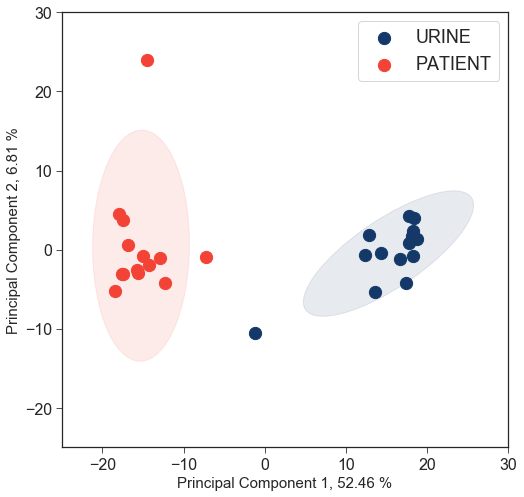

In [8]:
f = plotPCA(pDf, pc1, pc2, "MEDIA", col=[col5, col1], nameby="", el=True)
ax = f.gca()
ax.set_xlim((-25, 30))
ax.set_ylim((-25, 30))
fn = os.path.join(figures_dir, "Figure_2c.png")
f.savefig(fn, dpi = 500, bbox_inches="tight")

In [11]:
strain_info

,STRAIN,MEDIA,PRED_PHYLO,HISTORY
HM01 | URINE,HM01,URINE,E,N
HM01 | PATIENT,HM01,PATIENT,E,N
HM03 | URINE,HM03,URINE,B1,N
HM03 | PATIENT,HM03,PATIENT,B1,N
HM06 | URINE,HM06,URINE,B2,N
HM06 | PATIENT,HM06,PATIENT,B2,N
HM07 | URINE,HM07,URINE,B1,Y
HM07 | PATIENT,HM07,PATIENT,B1,Y
HM14 | URINE,HM14,URINE,B1,Y
HM14 | PATIENT,HM14,PATIENT,B1,Y


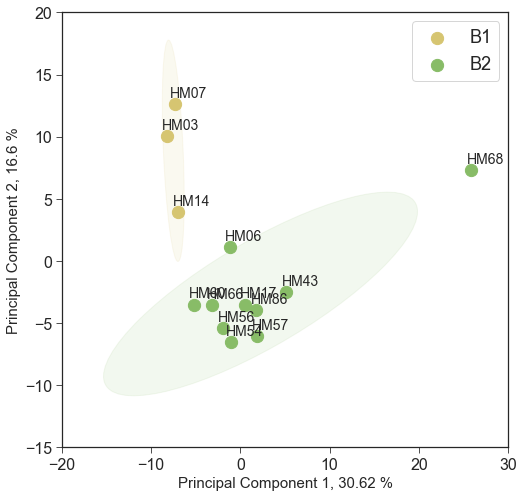

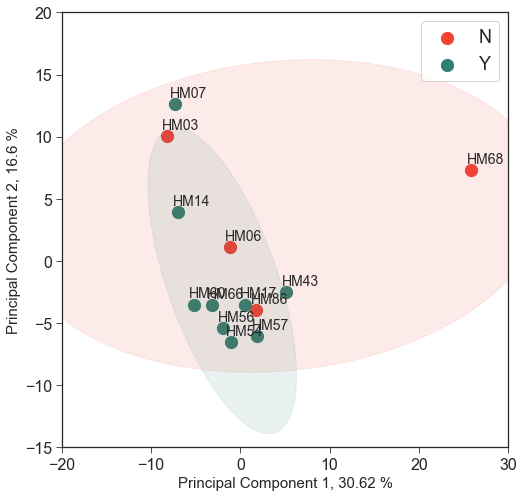

In [26]:
#URINE ALONE for history and phylogroup PCA
#REMOVE E STRAIN: Can't draw CI for 1 point (HM01)

nurine = ntpms[[c for c in ntpms.columns if ur in c and not "HM01" in c]]
nurine.columns = [c.strip() for c in nurine.columns]
urine_meta = strain_info.loc[[c.strip() for c in nurine.columns if ur in c]]
pDf, pc1, pc2 = find_pc1_pc2(nurine, urine_meta)

f = plotPCA(pDf, pc1, pc2, "PRED_PHYLO", col=[col2, col3], nameby="STRAIN", el=True)
ax = f.gca()
ax.set_xlim((-20, 30))
ax.set_ylim((-15, 20))
#fn =  os.path.join(figures_dir, "Figure_3b_with_outlier.png")
#f.savefig(fn, dpi = 500, bbox_inches="tight")

f = plotPCA(pDf, pc1, pc2, "HISTORY", col=[col1, col4], nameby="STRAIN",  el=True)
ax = f.gca()
ax.set_xlim((-20, 30))
ax.set_ylim((-15, 20))
fn =  os.path.join(supplement_dir, "Supplemental_Figure_5a.png")
f.savefig(fn, dpi = 500, bbox_inches="tight")

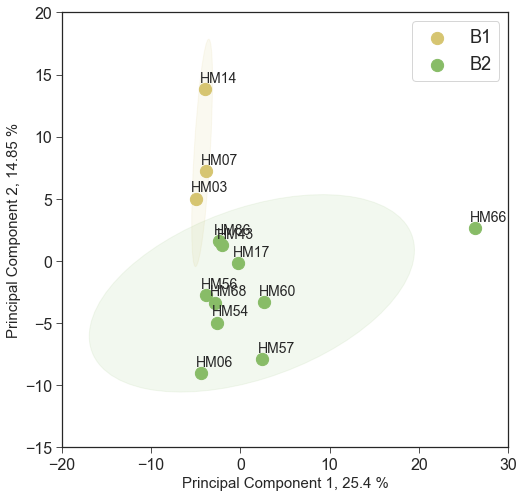

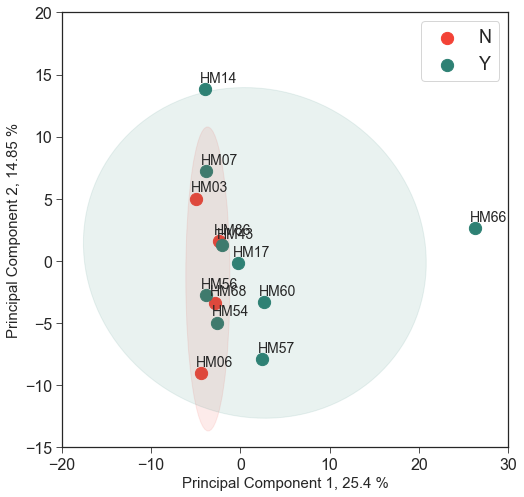

In [27]:
# UTI ALONE for history and phylogroup analysis

nuti = ntpms[[c for c in ntpms.columns if uti in c and not "HM01" in c]]
nuti.columns = [c.strip() for c in nuti.columns]
uti_meta = strain_info.loc[[c.strip() for c in nuti.columns if uti in c]]
pDf, pc1, pc2 = find_pc1_pc2(nuti, uti_meta)
f = plotPCA(pDf, pc1, pc2, "PRED_PHYLO", col=[col2, col3], nameby="STRAIN", el=True)
ax = f.gca()
ax.set_xlim((-20, 30))
ax.set_ylim((-15, 20))
fn =  os.path.join(figures_dir, "Figure_3c_with_outlier.png")
f.savefig(fn, dpi = 500, bbox_inches="tight")
f = plotPCA(pDf, pc1, pc2, "HISTORY", col=[col1, col4], nameby="STRAIN",  el=True)
ax = f.gca()
ax.set_xlim((-20, 30))
ax.set_ylim((-15, 20))
fn =  os.path.join(supplement_dir, "Supplementary_Figure_5b.png")
f.savefig(fn, dpi = 500, bbox_inches="tight")